# Learning linear conservative system using a symplectic neural network

In this notebook we will use a structure-preserving neural network to learn a function $\phi:\mathbb{R}^n\rightarrow\mathbb{R}^n$ from a data of the form $\{x_i, \phi(x_i)\}_{i=1}^m$, where the $x_i$ are generated randomly. 

We know that the unknown function $\phi$ is the solution of linear conservative ODE $\dot{x} = JMx$, where $J=-J^T$ is a symplectic matrix and $M=M^T$ is a symmetric matrix. 

In [1]:
from utils import create_gif, generate_linear_hamiltonian_data, generate_linear_hamiltonian_trajectory
import torch 

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)

# Generate a dataset of exact solutions of a linear Hamiltonian system
DIM = 100
TIMESTEP = torch.tensor([0.05])
NDATA = 1000

x0, x1 = generate_linear_hamiltonian_data(
    dim=DIM, 
    ndata=NDATA, 
    timestep=TIMESTEP,
)

### Initialize the Hamiltonian neural network (P-SympNet) using the StruPNET package

In [2]:
from strupnet import SympNet

sympnet = SympNet(
    dim=DIM,
    max_degree=2,
    layers=2*DIM,
    method='P',
)

### Train the Hamiltonian neural network using the Adams optimiser

/Users/bentapley/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [03:21<00:00,  4.97it/s, train_loss=8.85e-13]

Final loss value:  8.845675216925325e-13


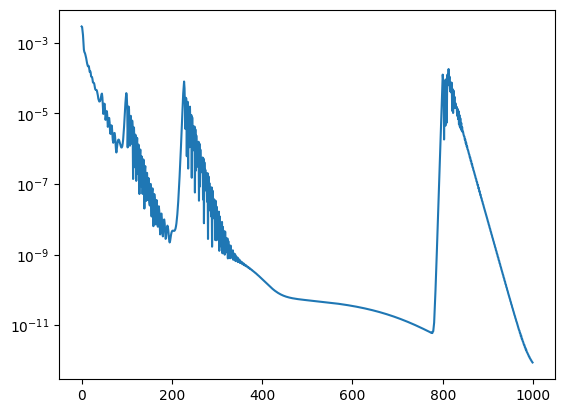

In [3]:
from utils import train
import matplotlib.pyplot as plt

NEPOCHS = 3000
LEARNING_RATE = 0.02
WEIGHT_DECAY = 1e-10

training_curve = train(
    net=sympnet,
    x0=x0,
    x1=x1,
    lr=LEARNING_RATE,
    nepochs=NEPOCHS,
    tol=1e-14,
    weight_decay=WEIGHT_DECAY,
    use_best_train_loss=True, 
)

plt.semilogy(training_curve)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss curve')
plt.show()

### Compare the prediction with the true solution

GIF saved as prediction.gif


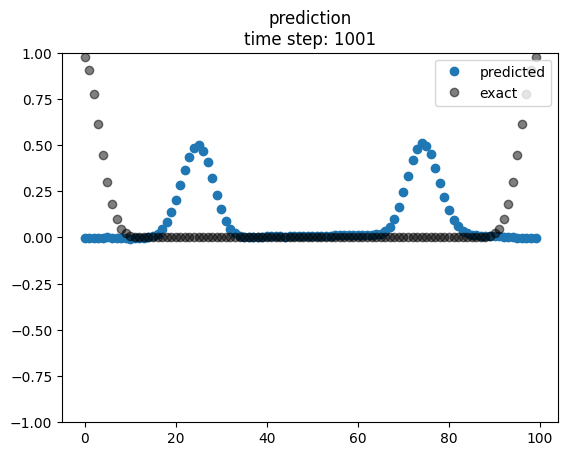

In [4]:
NSTEPS = 1000

z = torch.linspace(-1, 1, DIM)
p0, q0 = torch.zeros(DIM), torch.exp(-z**2*100)
true_sol = generate_linear_hamiltonian_trajectory(p0, q0, TIMESTEP, NSTEPS)

# get predicted solution
pred_sol = torch.zeros(NSTEPS + 1, 2*DIM)
pred_sol[0, :] = true_sol[0, :]
for i in range(NSTEPS):
    pred_sol[i+1, :] = sympnet(x=pred_sol[i, :], dt=TIMESTEP).detach()

create_gif(pred_sol[:, DIM:], exact_solution=true_sol[:, DIM:], title='prediction', duration=0.00001)
